### Подключаемые модули

In [1]:
import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn import metrics
from tqdm.notebook import tqdm

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

### Загрузка данных

In [2]:
df = pd.read_csv("train.csv", index_col=["Date"], parse_dates=["Date"])
df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106


### Анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6255 entries, 2010-01-10 to 2012-10-08
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Weekly_Sales  6255 non-null   float64
 2   Temperature   6255 non-null   float64
 3   Fuel_Price    6255 non-null   float64
 4   CPI           6255 non-null   float64
 5   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 342.1 KB


In [4]:
df.describe()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000,6255.000000
mean,23.000000,1.047722e+06,60.647365,3.344193,171.439895,8.025884
std,12.988211,5.654876e+05,18.623215,0.455260,39.297817,1.875644
min,1.000000,2.099862e+05,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.538695e+05,47.170000,2.917000,131.735000,6.908000
50%,23.000000,9.609985e+05,62.730000,3.413000,182.610406,7.906000
75%,34.000000,1.422573e+06,75.210000,3.722000,212.488702,8.622000
max,45.000000,3.818686e+06,100.140000,4.308000,226.966232,14.313000


In [10]:
print('Store NaN values count: ', df['Store'].isnull().sum())
print('Weekly_Sales NaN values count: ', df['Weekly_Sales'].isnull().sum())
print('Temperature NaN values count: ', df['Temperature'].isnull().sum())
print('Fuel_Price NaN values count: ', df['Fuel_Price'].isnull().sum())
print('CPI NaN values count: ', df['CPI'].isnull().sum())
print('Unemployment NaN values count: ', df['Unemployment'].isnull().sum())

Store NaN values count:  0
Weekly_Sales NaN values count:  0
Temperature NaN values count:  0
Fuel_Price NaN values count:  0
CPI NaN values count:  0
Unemployment NaN values count:  0


<Axes: >

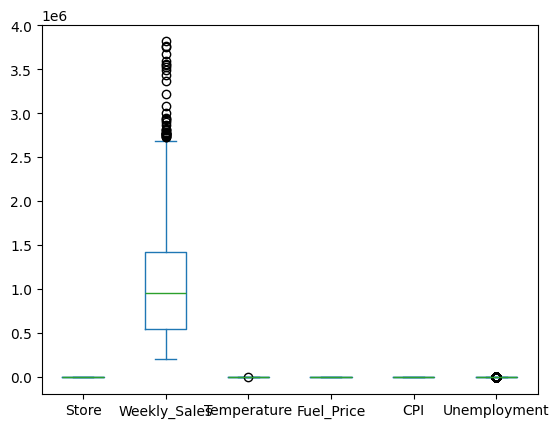

In [9]:
df.plot.box()

Можно сказать, что выбросов в целом нет.Будем считать, что выделяющиеся значения Weekly_Sales, связанны либо с сезоннностью, либо с особенностью магазина. Мб какие-то из них слишком популярные и поэтому выручка у низ больше. Особенно в сезон.

In [ ]:
def plotly_series(series, title=""):
    data = []

    # for column in df.columns:
    #     trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
    trace = go.Scatter(x=df.index, y=series, mode="lines", name='weekly_sales')
    data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

store_df = df[df['Store'] == 2]
plotly_series(store_df['Weekly_Sales'], title="weekly_sales")

AttributeError: 'Series' object has no attribute 'columns'

### Подготовка и очистка данных

In [ ]:
df = df.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1)
df['Alpha'] = 0
df['Betta'] = 0
df['Gamma'] = 0
df.head()

### Обучение и тестирование моделей

In [ ]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = min(slen, len(self.series))
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            if self.slen + i >= len(self.series):
                break
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            if n_seasons != 0: 
                seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x, data):
    # вектор ошибок
    errors = []
    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=10)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen= 52,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
            scaling_factor=2.56
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = metrics.mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [ ]:
def optimizeGroup(groupData):
    alpha_final, betta_final, gamma_final = 0, 0, 0
    data = groupData.Weekly_Sales[:-52]
    koefs = [0, 0, 0]    
    opt = minimize(timeseriesCVscore, x0=koefs, method="TNC", bounds=((0, 1), (0, 1), (0, 1)), args=(data))
        
    alpha_final, betta_final, gamma_final = opt.x
    
    result = pd.Series()
    result['Alpha'] = alpha_final
    result['Betta'] = betta_final
    result['Gamma'] = gamma_final
    return result#groupData#[['Alpha', 'Betta', 'Gamma']]


optimized_df = df.groupby(by='Store')[['Weekly_Sales']].apply(func=optimizeGroup)
optimized_df.head()


In [ ]:
def plotHoltWinters(data, model):
    # Anomalies = np.array([np.nan] * len(data))
    # Anomalies[data.values < model.LowerBond] = data.values[
    #     data.values < model.LowerBond
    # ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    #plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13)
    plt.show()

In [ ]:
predicts = []

i = 0
sr = []
for alpha, betta, gamma in optimized_df.values:
    i += 1
    data = df[df['Store'] == i]['Weekly_Sales']
    model = HoltWinters(
        data[:],
        slen= 52,
        alpha=alpha,
        beta=betta,
        gamma=gamma,
        n_preds=4,
        scaling_factor=2.56,   
    )
    # print(data)
    model.triple_exponential_smoothing()
    # plotHoltWinters(data, model)
    # #print(len(model.result))
    Y = df['Weekly_Sales'][-4:]
    # print(len(Y))
    # print("Y:", Y, "Model:", model.result[-4:])
    print(i, metrics.mean_absolute_percentage_error(Y, model.result[-4:]))
    sr.append(metrics.mean_absolute_percentage_error(Y, model.result[-4:]))
    predicts.append(model.result[-4])
    predicts.append(model.result[-3])
    predicts.append(model.result[-2])
    predicts.append(model.result[-1])
    
print('sr: ', sum(sr) / len(sr))
predicts   


Метрика MAPE оставляет желать лучшего. Попробую другую модель

### Обучение и тестирование моделей

### Сабмит

In [ ]:
data = {
    "source_attractiveness" : predicts
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")